모듈 import

In [1]:
!pip install pandas_datareader
!pip install pmdarima

import os

import pandas as pd
import pandas_datareader.data as pdr
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 36.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
# 2017-10-19 부터 5년간 삼성전자 주식 데이터
# 데이터를 읽어들인 뒤 날짜와 종가의 데이터만 남김

data = pd.read_csv('samsung.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Close']]
data = data.set_index('Date')
data

,Close
Date,
2017-10-19,52980
2017-10-20,53840
2017-10-23,54300
2017-10-24,54040
2017-10-25,53900
...,...
2022-10-13,55200
2022-10-14,56300
2022-10-17,56600


ARIMA 모델링

1. 데이터 전처리

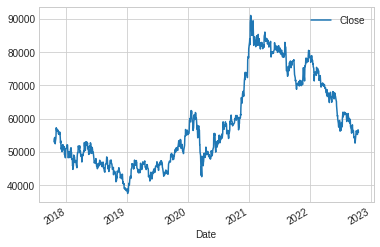

In [3]:
#원본 데이터
fig = data.plot()

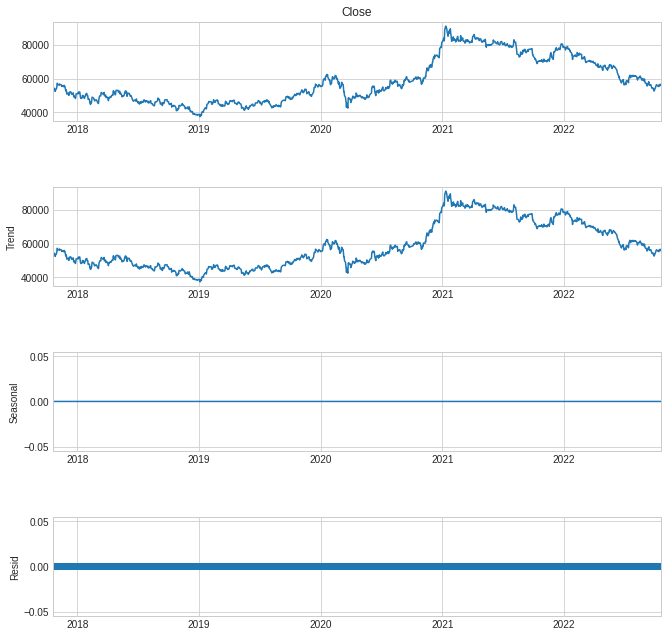

In [4]:
# 시계열 분해

# 첫 번째 plot은 원본 데이터
# Trend: 상승과 하락이 있는 추세 변동
# Seasonal: 분기마다 반복되는 계절 변동
# resid: residual, 예측 불가능한 임의의 변동. 원래 데이터에서 추세, 순환, 계절성을 뺀 나머지를 의미한다.

decomposition = sm.tsa.seasonal_decompose(data['Close'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

2. 시범적으로 시행해 볼 만한 모델 찾기

In [5]:
# 훈련데이터와 테스트 데이터를 8:2 비율로 나눔

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [6]:
# 몇 차 차분이 최선일지 파악하기 위해 ndiffs 함수를 사용할 수 있다.

from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


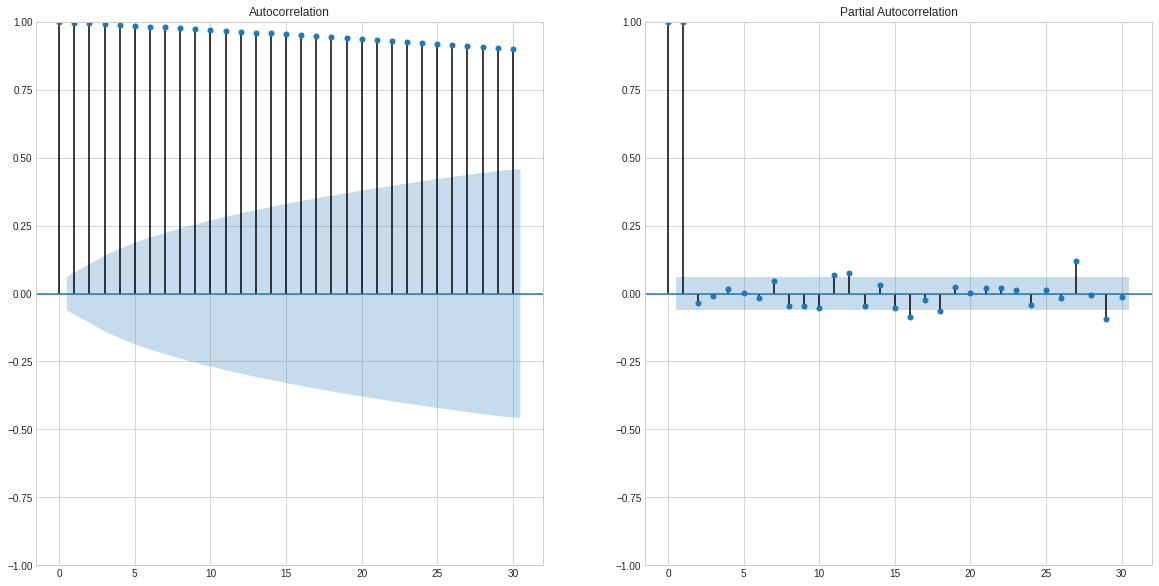

In [7]:
# ACF, PACF
# squeeze()는 차원이 1인 차원을 제거해 줌.

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]);

In [8]:
# 원본 데이터에 1차 차분
# DataFrame.diff(periods=1, axis=0): 차분, 기본값은 1차
# 80%만 train_data로 사용했기 때문에 2021-10-18까지의 데이터만 존재

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff()    # 종가에 대해 차분
diff_train_data = diff_train_data.dropna()           # 차분으로 인한 결측치 제거
print(train_data)
print(diff_train_data)

            Close
Date             
2017-10-19  52980
2017-10-20  53840
2017-10-23  54300
2017-10-24  54040
2017-10-25  53900
...           ...
2021-10-12  69000
2021-10-13  68800
2021-10-14  69400
2021-10-15  70100
2021-10-18  70200

[982 rows x 1 columns]
Date
2017-10-20     860.0
2017-10-23     460.0
2017-10-24    -260.0
2017-10-25    -140.0
2017-10-26   -1500.0
               ...  
2021-10-12   -2500.0
2021-10-13    -200.0
2021-10-14     600.0
2021-10-15     700.0
2021-10-18     100.0
Name: Close, Length: 981, dtype: float64


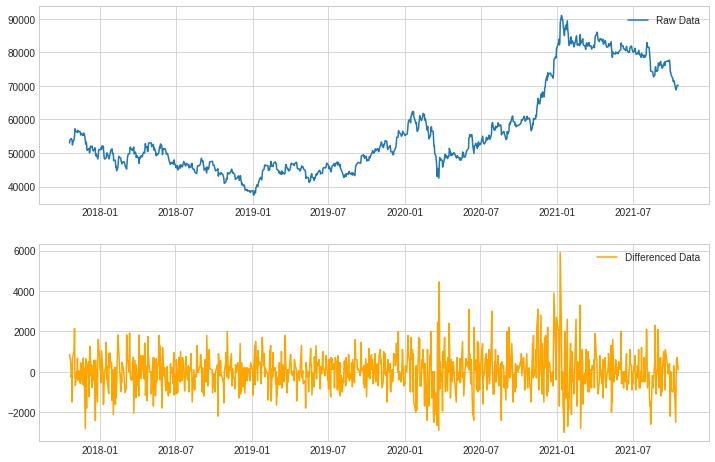

In [9]:
# 1차 차분을 적용한 데이터의 plot
# plt.subplot(nrows, ncols, index): 큰 틀에서 어느 위치에 세부 plot을 그릴지 결정

plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(train_data['Close'])
plt.legend(['Raw Data'])

plt.subplot(2, 1, 2)
plt.plot(diff_train_data, color='orange')
plt.legend(['Differenced Data'])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


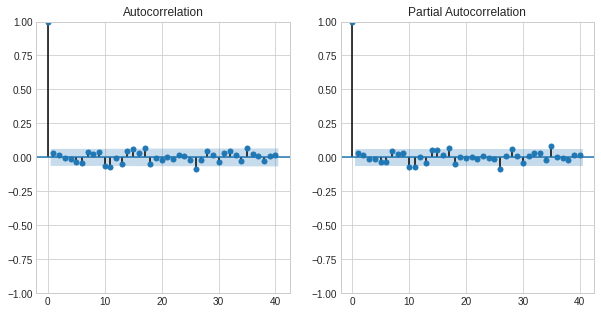

In [10]:
# 1차 차분한 데이터의 ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=40, ax=ax[1]);

3. 파라미터 추정

In [11]:
# AR, difference, MA에 임의의 값을 설정하여 모델 생성

model = ARIMA(train_data.values, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  982
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8116.739
Date:                Fri, 28 Oct 2022   AIC                          16241.478
Time:                        03:24:30   BIC                          16261.033
Sample:                             0   HQIC                         16248.917
                                - 982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5182      0.867     -0.598      0.550      -2.217       1.180
ma.L1          0.5501      0.868      0.634      0.526      -1.150       2.250
ma.L2          0.0356      0.032      1.116      0.264      -0.027       0.098
sigma2      9.024e+05   2.68e+04     33.622      0.000     8.5e+05    9.55e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               307.91
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

4.1 모델이 괜찮은지 확인 - ARIMA

In [12]:
# 여러 조합의 p,d,q를 탐색

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,4)
d = range(1,3)
q = range(0,4)
pdq = list(itertools.product(p, d, q))

aic=[]
for i in pdq:
  model = ARIMA(train_data.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic,2))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 1, 0) >> AIC : 16238.04
ARIMA: (0, 1, 1) >> AIC : 16238.35
ARIMA: (0, 1, 2) >> AIC : 16239.68
ARIMA: (0, 1, 3) >> AIC : 16241.6
ARIMA: (0, 2, 0) >> AIC : 16870.46
ARIMA: (0, 2, 1) >> AIC : 16568.89
ARIMA: (0, 2, 2) >> AIC : 16483.43
ARIMA: (0, 2, 3) >> AIC : 16474.84
ARIMA: (1, 1, 0) >> AIC : 16238.27
ARIMA: (1, 1, 1) >> AIC : 16239.99
ARIMA: (1, 1, 2) >> AIC : 16241.48
ARIMA: (1, 1, 3) >> AIC : 16243.6
ARIMA: (1, 2, 0) >> AIC : 16699.0
ARIMA: (1, 2, 1) >> AIC : 16473.3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1, 2, 2) >> AIC : 16475.4
ARIMA: (1, 2, 3) >> AIC : 16476.78
ARIMA: (2, 1, 0) >> AIC : 16239.71
ARIMA: (2, 1, 1) >> AIC : 16241.5
ARIMA: (2, 1, 2) >> AIC : 16228.43
ARIMA: (2, 1, 3) >> AIC : 16229.99
ARIMA: (2, 2, 0) >> AIC : 16632.33
ARIMA: (2, 2, 1) >> AIC : 16475.24
ARIMA: (2, 2, 2) >> AIC : 16476.25


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: (2, 2, 3) >> AIC : 16478.23
ARIMA: (3, 1, 0) >> AIC : 16241.56
ARIMA: (3, 1, 1) >> AIC : 16243.57
ARIMA: (3, 1, 2) >> AIC : 16245.35
ARIMA: (3, 1, 3) >> AIC : 16232.19
ARIMA: (3, 2, 0) >> AIC : 16598.91
ARIMA: (3, 2, 1) >> AIC : 16476.61
ARIMA: (3, 2, 2) >> AIC : 16478.22
ARIMA: (3, 2, 3) >> AIC : 16473.41


In [13]:
# 최적의 파라미터

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 16228.43)]

In [14]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  982
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8109.215
Date:                Fri, 28 Oct 2022   AIC                          16228.431
Time:                        03:24:55   BIC                          16252.874
Sample:                             0   HQIC                         16237.729
                                - 982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1737      0.044     26.958      0.000       1.088       1.259
ar.L2         -0.9114      0.044    -20.483      0.000      -0.999      -0.824
ma.L1         -1.1379      0.045    -25.271      0.000      -1.226      -1.050
ma.L2          0.9063      0.047     19.208      0.000       0.814       0.999
sigma2      9.024e+05    2.8e+04     32.178      0.000    8.47e+05    9.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               304.31
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

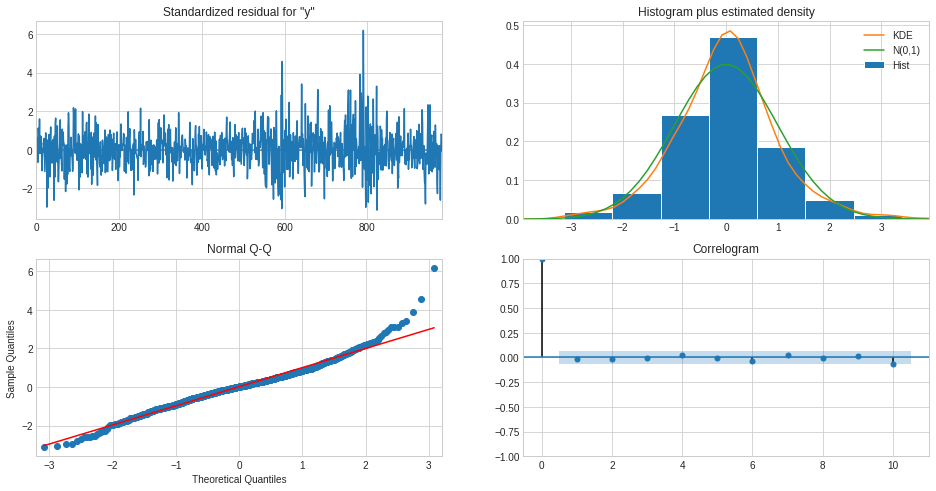

In [15]:
model_opt_fit.plot_diagnostics(figsize=(16,8));

5.1 예측 모델로 사용 - ARIMA

In [16]:
# 결정 계수 확인

prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction

'''arima.model.ARIMA에서는 forecast의 리턴형식이 달라서 확률 범위를 나타낼 수 없음.
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
'''

predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
print(r2)

-0.21043943694136025


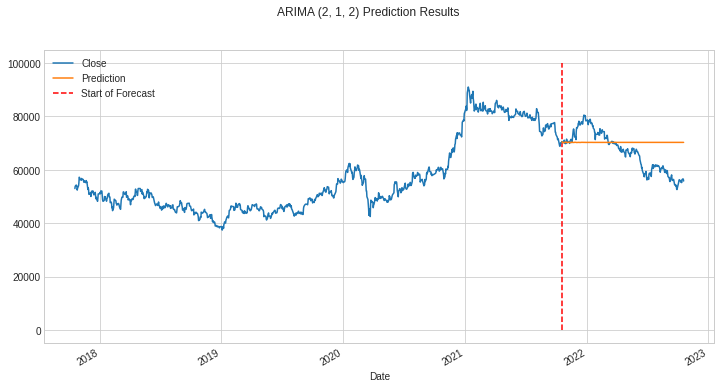

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('2021-10-19', 0, 100000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
#ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results')
plt.show()

4.2 모델이 괜찮은지 확인 - SARIMA

In [ ]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 2)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic = []
params = []
for i in pdq:
  for j in seasonal_pdq:
    try:
      model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
      model_fit = model.fit()
      print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}')
      aic.append(round(model_fit.aic, 2))
      params.append((i, j))
    except:
      continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 16712.76
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 16362.38
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 16317.6
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 16524.08
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 16316.87
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 16318.23
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 16707.59
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 16363.18
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 16316.59
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 16521.34
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 16325.37
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 16317.45
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 16708.89
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 16363.79
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 16317.94
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : 16521.88
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : 16326.69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : 16319.79
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : 16707.34
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : 16363.11
SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : 16316.49
SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : 16521.09
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : 16325.24


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : 16317.33
SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : 16709.27
SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : 16366.38


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : 16318.21
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : 16522.42


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(1, 1, 1, 12) >> AIC : 16320.67


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : 16322.16
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : 16684.46
SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : 16365.59
SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : 16320.59


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : 16525.33
SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : 16320.02
SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : 16330.83


In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (0, 1, 2, 12)), 16316.49)]

In [ ]:
model_opt = SARIMAX(train_data.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  982
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -8154.245
Date:                                 Thu, 27 Oct 2022   AIC                          16316.490
Time:                                         06:39:47   BIC                          16335.995
Sample:                                              0   HQIC                         16323.915
                                                 - 982                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0440      0.025      1.753      0.080      -0.005       0.093
ma.S.L12      -0.6993      0.013    -55.632      0.000      -0.724      -0.675
ma.S.L24      -0.2021      0.008    -26.146      0.000      -0.217      -0.187
sigma2      1.059e+06    3.2e+04     33.110      0.000    9.96e+05    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               746.38
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.37
Prob(H) (two-sided):                  0.27   Kurtosis:                         7.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

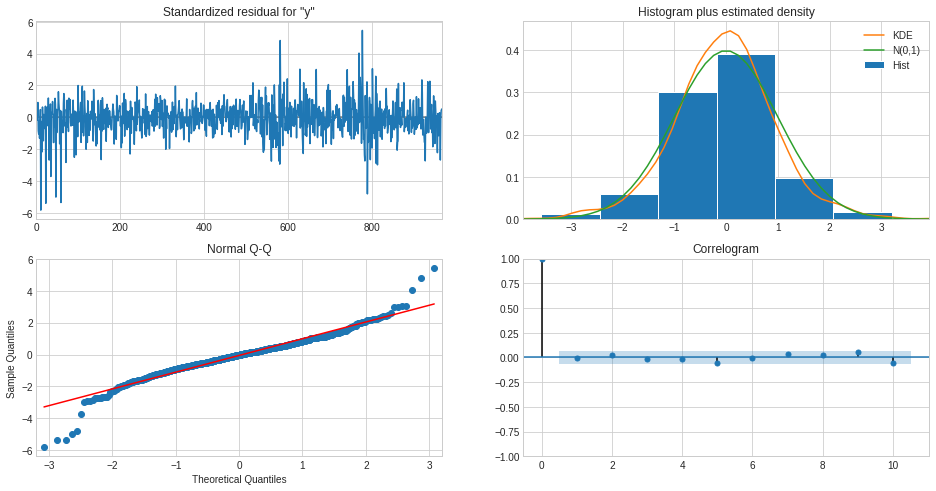

In [ ]:
model_opt_fit.plot_diagnostics(figsize=(16,8));

5.2 예측모델로 사용 - SARIMA

In [ ]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

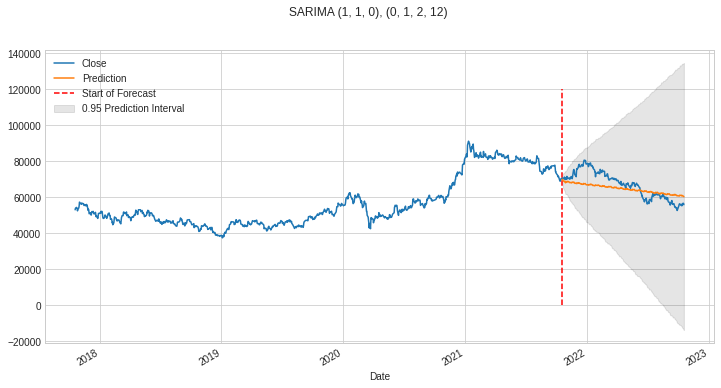

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('2021-10-19', 0, 120000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]}')
plt.show()

4.3 모델이 괜찮은지 확인 - auto_arima(seasonal=False)

In [ ]:
# 최적의 조합을 찾아 모델을 만듦.

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,max_p=3, max_q=3, m=12, seasonal=False, d=1, D=1, max_P=3, max_Q=3,
                              trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16239.699, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16240.058, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16241.416, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16243.346, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16239.990, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16241.751, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16243.238, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16245.341, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16241.454, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16243.253, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16230.181, Time=1.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16231.676, Time=2.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16243.286, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16245.293, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16247.131, Time=0.82

In [ ]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  982
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -8109.090
Date:                Thu, 27 Oct 2022   AIC                          16230.181
Time:                        06:43:08   BIC                          16259.512
Sample:                             0   HQIC                         16241.339
                                - 982                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.6461     24.149      0.689      0.491     -30.684      63.976
ar.L1          1.1739      0.043     26.988      0.000       1.089       1.259
ar.L2         -0.9118      0.044    -20.497      0.000      -0.999      -0.825
ma.L1         -1.1382      0.045    -25.316      0.000      -1.226      -1.050
ma.L2          0.9066      0.047     19.235      0.000       0.814       0.999
sigma2      9.022e+05   2.87e+04     31.435      0.000    8.46e+05    9.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               304.35
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

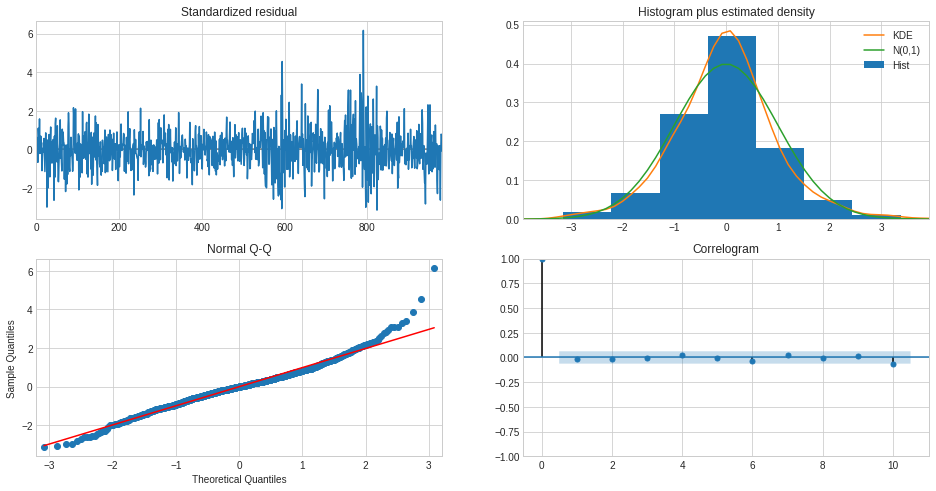

In [ ]:
auto_arima_model.plot_diagnostics(figsize=(16,8));

5.3 예측모델로 사용 - auto_arima(seasonal=False)

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
print(r2)

-1.1363929014210705


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


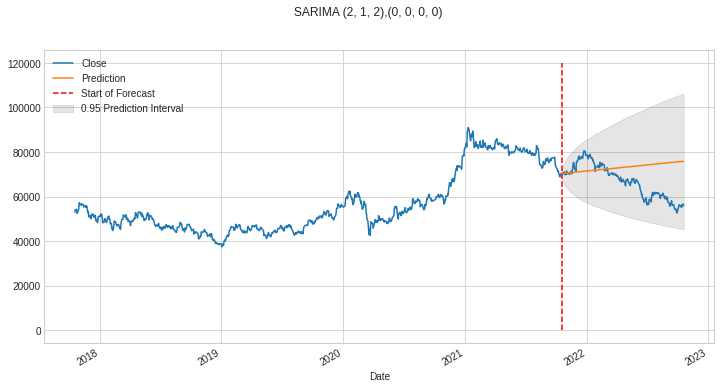

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('2021-10-19', 0, 120000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order}')
plt.show()

4.4 모델이 괜찮은지 확인 - auto_arima(seasonal=True)

In [ ]:
# max_p, max_q, max_P, max_Q를 모두 1로 설정하고 최적의 조합을 찾아 모델을 만듦.

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,max_p=1, max_q=1, m=12,
                              seasonal=True, d=1, D=1, max_P=1, max_Q=2,trace=True,
                              error_action='ignore', suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16712.764, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=16362.376, Time=1.56 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=16524.085, Time=0.71 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=4.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=16707.592, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=16363.184, Time=3.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=10.97 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=16521.339, Time=2.61 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=5.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=16.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=16707.344, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=16363.107, Time=2.99 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=9.40 sec
 ARIMA(1,1,0)(1,1,0)

In [ ]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  982
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -8179.188
Date:                              Thu, 27 Oct 2022   AIC                          16362.376
Time:                                      06:46:26   BIC                          16372.129
Sample:                                           0   HQIC                         16366.089
                                              - 982                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7448      0.009    -78.933      0.000      -0.763      -0.726
sigma2      1.085e+06   3.22e+04     33.714      0.000    1.02e+06    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):              4232.31
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -1.03
Prob(H) (two-sided):                  0.86   Kurtosis:                        13.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

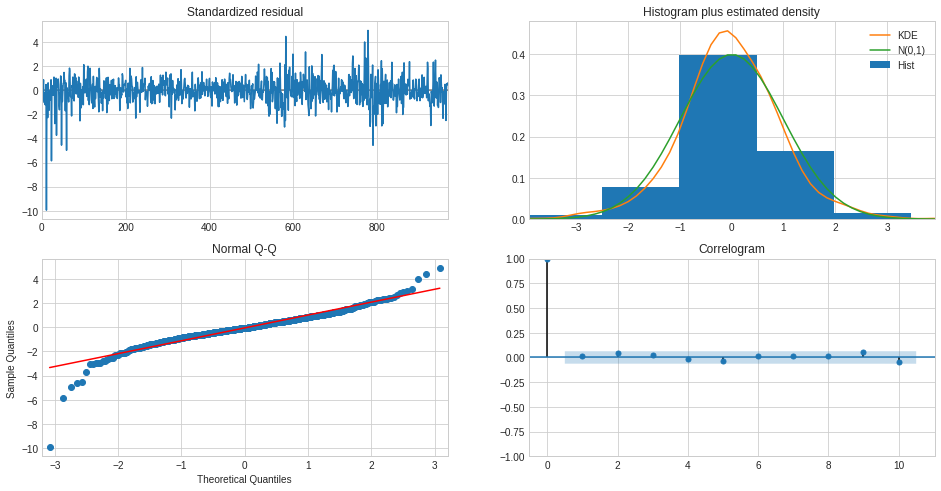

In [ ]:
auto_arima_model.plot_diagnostics(figsize=(16,8));

5.4 예측모델로 사용 - auto_arima(seasonal=True)

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
print(r2)

-4.58338957868627


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


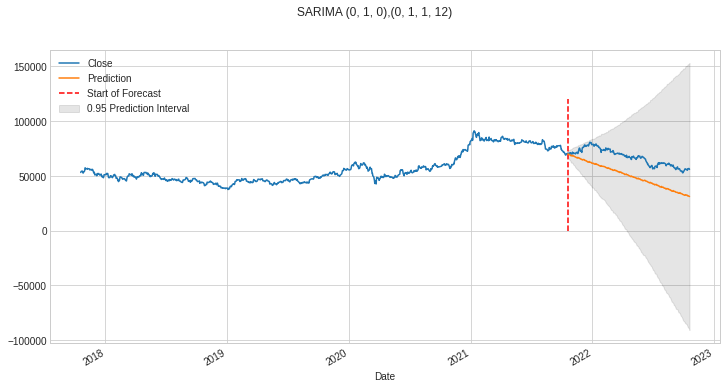

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('2021-10-19', 0, 120000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order}')
plt.show()